[*********************100%***********************]  1 of 1 completed


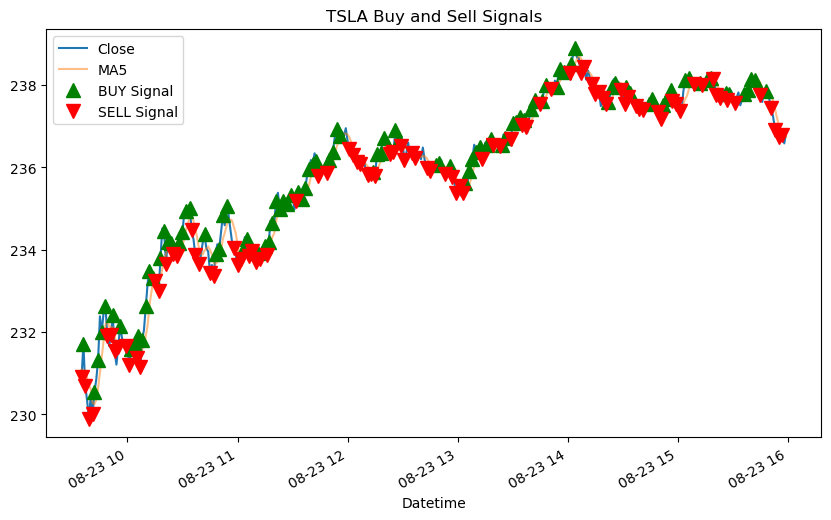

Total return without strategy: 2.62%
Total return with strategy: 14.16%


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 下载数据
data = yf.download('TSLA', start='2023-08-23', end='2023-08-24', interval='1m')
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)
# 将返回划分为两个状态：上涨和下跌
bins = [-np.inf, 0, np.inf]
labels = [0, 1]  # 0 for down, 1 for up
data['State'] = pd.cut(data['Return'], bins=bins, labels=labels).astype(int)
# 计算转移概率矩阵
matrix_size = 2
transition_matrix = np.zeros((matrix_size, matrix_size))
for i in range(1, len(data)):
    from_state = data['State'].iloc[i-1]
    to_state = data['State'].iloc[i]
    transition_matrix[from_state, to_state] += 1
# 归一化
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
# 使用5分钟的移动平均
data['MA5'] = data['Close'].rolling(window=5).mean()
data.dropna(inplace=True)  # 删除前5个数据点
signals = []
state = data['State'].iloc[0]  # 第一个状态
for i, row in data.iterrows():
    next_state = np.argmax(transition_matrix[state])
    if row['Close'] > row['MA5'] and next_state == 1:
        signals.append(1)  # Buy
    elif row['Close'] < row['MA5'] and next_state == 0:
        signals.append(-1)  # Sell
    else:
        signals.append(0)  # Hold/Do nothing
    state = next_state
data['Signal'] = signals
# 绘制买卖信号
plt.figure(figsize=(10,6))
data['Close'].plot()
data['MA5'].plot(alpha=0.5)
buy_signals = data[data['Signal'] == 1]
sell_signals = data[data['Signal'] == -1]
plt.plot(buy_signals.index, data['Close'][buy_signals.index], '^', markersize=10, color='g', lw=0, label='BUY Signal')
plt.plot(sell_signals.index, data['Close'][sell_signals.index], 'v', markersize=10, color='r', lw=0, label='SELL Signal')
plt.title('TSLA Buy and Sell Signals')
plt.legend()
plt.show()
# 计算收益率
data['Strategy Return'] = data['Return'] * data['Signal']
cum_strategy_return = (data['Strategy Return'] + 1).cumprod()
cum_return = (data['Return'] + 1).cumprod()
print(f"Total return without strategy: {(cum_return.iloc[-1] - 1) * 100:.2f}%")
print(f"Total return with strategy: {(cum_strategy_return.iloc[-1] - 1) * 100:.2f}%")

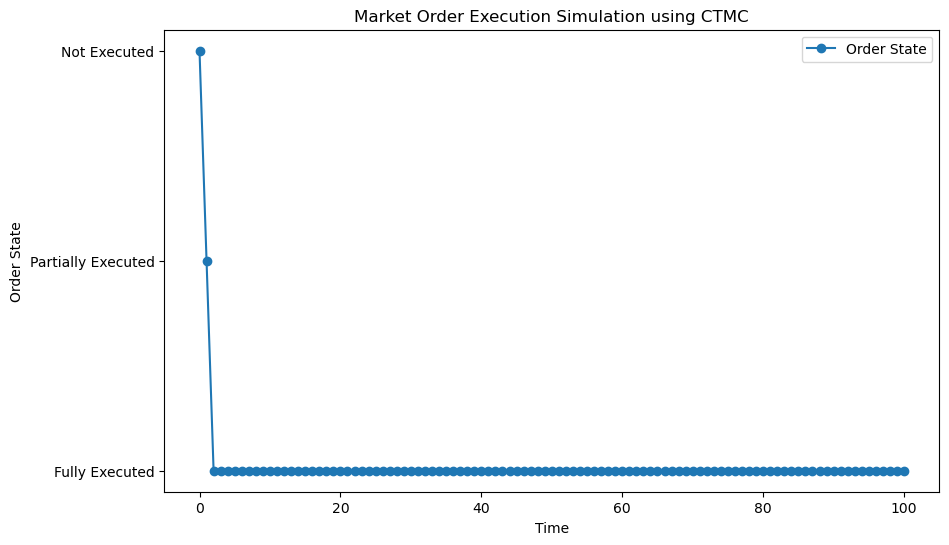

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# 定义转移强度矩阵
λ12, λ21, λ23 = 0.05, 0.01, 0.02
Q = np.array([[-λ12, λ12, 0],
              [λ21, -(λ21+λ23), λ23],
              [0, 0, 0]])
def simulate_order_execution(num_steps=100):
    state = 2
    states = [state]
    for _ in range(num_steps):
        if state == 2:  # 如果订单未被执行
            state = np.random.choice([1, 2], p=[λ12 / (λ12), 1 - λ12 / (λ12)]) 
        elif state == 1:  # 如果订单被部分执行
            next_state_prob = [λ23 / (λ21+λ23), λ21 / (λ21+λ23), 1 - (λ21+λ23) / (λ21+λ23)]
            state = np.random.choice([0, 1, 2], p=next_state_prob) 
        states.append(state)
    return states
states = simulate_order_execution()
# 绘制结果
plt.figure(figsize=(10,6))
plt.plot(states, '-o', label="Order State")
plt.yticks([0, 1, 2], ["Fully Executed", "Partially Executed", "Not Executed"])
plt.title("Market Order Execution Simulation using CTMC")
plt.xlabel("Time")
plt.ylabel("Order State")
plt.legend()
plt.show()